# Predicting Dog Bites in NYC

## INFO 1998 Fall '23 Final Project 

### By Elisabeth Pan, Victoria Varkonyi

#### Introduction

In this project, we perform explorative data and predictive analysis on a dataset containing information about dog bites in NYC from the years of 2015 to 2021.

We want to answer the following questions:
1. Are dogs more likely to bite during different times of the year?
2. What features of dogs (location, breed, gender) are most correlated with each other?
3. Given certain features, can we predict the gender of a dog? 
4. Can we accurately predict whether or not a dog is more likely to be neutered based on its zipcode?

Here we outline our approach to this task:
1. Import necessary packages, preprocess, clean, and manipulate dataset
2. Data Visualizations
3. Machine Learning Models

## Step 1: Importing data, preprocessing and cleaning data

In [36]:
# Package imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.cluster import KMeans

In [4]:
# Load and preview data
original = pd.read_csv('dog bites/Dog_Bites_Data.csv')
original.info()
original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22663 entries, 0 to 22662
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UniqueID    22663 non-null  int64 
 1   DateOfBite  22663 non-null  object
 2   Species     22663 non-null  object
 3   Breed       20445 non-null  object
 4   Age         11442 non-null  object
 5   Gender      22663 non-null  object
 6   SpayNeuter  22663 non-null  bool  
 7   Borough     22663 non-null  object
 8   ZipCode     16805 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 1.4+ MB


,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
1,2,January 04 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
2,3,January 06 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
3,4,January 08 2018,DOG,Mixed/Other,4,M,False,Brooklyn,11231
4,5,January 09 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


In [45]:
# Clean and manipulate data

# set index to unique ID values
df = original.set_index('UniqueID')

# convert date of bite to datetime object
df['DateOfBite'] = pd.to_datetime(df['DateOfBite'], format='%B %d %Y')

# extract month from date of bite and create new month column
df['Month'] = df['DateOfBite'].dt.month_name()

# create new date column that contains original string dates
original_dates = []
for i in range(len(df)):
    original_dates.append(original['DateOfBite'][i])
df['DateString'] = original_dates

# drop na values in age column
df = df.dropna(subset=['Age'])

# convert ages to float
df['Age'] = df['Age'].str.extract('(\d+)').astype(float)

# pop species column because all observations are dogs
df.pop('Species')

# preview dataset
df.head()

,DateOfBite,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,Month,DateString
UniqueID,,,,,,,,,
4,2018-01-08,Mixed/Other,4.0,M,False,Brooklyn,11231,January,January 08 2018
6,2018-01-03,BASENJI,4.0,M,False,Brooklyn,11231,January,January 03 2018
9,2018-01-04,American Pit Bull Mix / Pit Bull Mix,5.0,M,False,Brooklyn,11235,January,January 04 2018
10,2018-01-10,MIXED,3.0,F,False,Brooklyn,11208,January,January 10 2018
12,2018-01-07,Yorkshire Terrier Crossbreed,7.0,M,True,Brooklyn,11208,January,January 07 2018


In [46]:
# data without na values
df_na = df.dropna()
df_na.head()

,DateOfBite,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,Month,DateString
UniqueID,,,,,,,,,
4,2018-01-08,Mixed/Other,4.0,M,False,Brooklyn,11231,January,January 08 2018
6,2018-01-03,BASENJI,4.0,M,False,Brooklyn,11231,January,January 03 2018
9,2018-01-04,American Pit Bull Mix / Pit Bull Mix,5.0,M,False,Brooklyn,11235,January,January 04 2018
10,2018-01-10,MIXED,3.0,F,False,Brooklyn,11208,January,January 10 2018
12,2018-01-07,Yorkshire Terrier Crossbreed,7.0,M,True,Brooklyn,11208,January,January 07 2018


In [47]:
# Just miscellaneous information about the values in the dataset
print(f"The total number of observations in this dataset is {len(df)}.")

na_breed = df['Breed'].value_counts()['UNKNOWN']
na_gender = df['Gender'].value_counts()['U']
print(f"The number of dogs whose breed is unknown is {na_breed}.")
print(f"The number of dogs whose gender is unknown is {na_gender}.")

The total number of observations in this dataset is 11442.
The number of dogs whose breed is unknown is 305.
The number of dogs whose gender is unknown is 194.


## Data Visualizations

### In this graphical representation, we investigate the occurrence of dog bites throughout each month of the year. 
Are dogs more likely to bite during certain times of the year? Our hypothesis is that dog bites occur more frequently in the summer as heat may be a contributing factor to a rise in aggression in dogs.

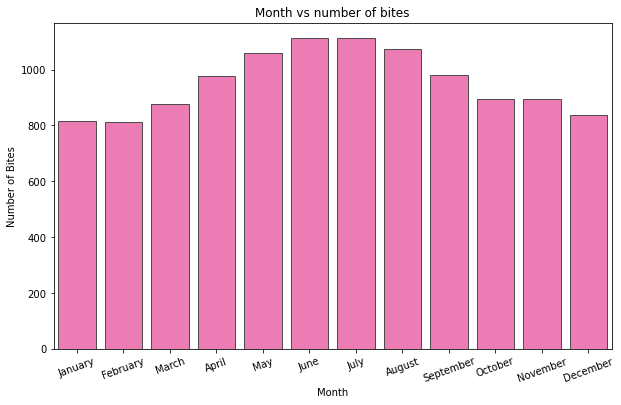

In [48]:
# Month vs. Number of Bites

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Month', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
              palette=['hotpink'], edgecolor=".3")
plt.xticks(rotation=20)
plt.title('Month vs number of bites')
plt.xlabel('Month')
plt.ylabel('Number of Bites')
plt.show()

#### Analysis
Our hypothesis is correct, there is a rise during the summer months, notably peaking in June, July, and August, marking the highest number of bites annually. 
This observation can be logically attributed to the fact that dogs may exhibit increased irritability and aggression in response to hot weather.

### In this graphical representation, we investigate the correlation between features in the dataset.
For example, is there a correlation between the breed of dog and the date of the bite? What about the breed of the dog and the borough it is located in? Is there a correlation between the date of the bite and the borough in which the dog bite happened? 

C:\Users\emmpa\AppData\Local\Temp\ipykernel_19636\1886521428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na[i] = encoder.fit_transform(df_na[i])


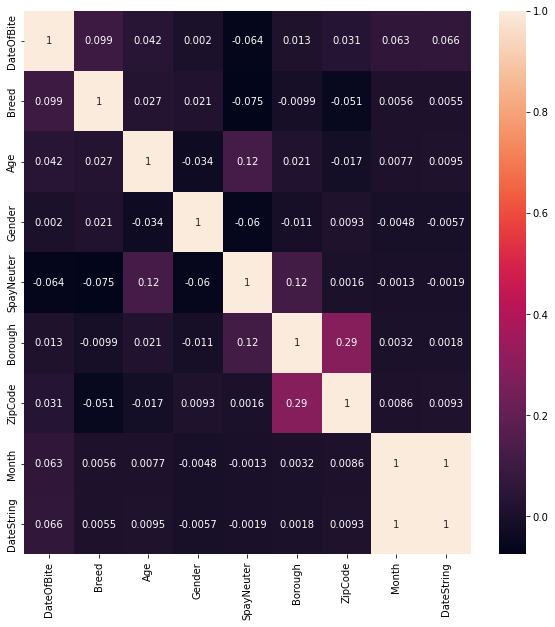

In [49]:
# correlation matrix of features in the data set
encoder = LabelEncoder()

for i in df.columns:
    df_na[i] = encoder.fit_transform(df_na[i])
    
df_na.reset_index(drop = True, inplace = True)
df_na.head()

corrMatrix = df_na.corr()

plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)

plt.show()

In [23]:
print(corrMatrix)

            DateOfBite     Breed       Age    Gender  SpayNeuter   Borough  \
DateOfBite    1.000000  0.098600  0.042450  0.002003   -0.063824  0.013086   
Breed         0.098600  1.000000  0.026645  0.021433   -0.075025 -0.009851   
Age           0.042450  0.026645  1.000000 -0.034310    0.119191  0.020646   
Gender        0.002003  0.021433 -0.034310  1.000000   -0.060451 -0.010751   
SpayNeuter   -0.063824 -0.075025  0.119191 -0.060451    1.000000  0.115782   
Borough       0.013086 -0.009851  0.020646 -0.010751    0.115782  1.000000   
ZipCode       0.031249 -0.050951 -0.017364  0.009289    0.001560  0.288233   
Month         0.062845  0.005607  0.007688 -0.004823   -0.001331  0.003242   
DateString    0.066142  0.005517  0.009530 -0.005687   -0.001860  0.001830   

             ZipCode     Month  DateString  
DateOfBite  0.031249  0.062845    0.066142  
Breed      -0.050951  0.005607    0.005517  
Age        -0.017364  0.007688    0.009530  
Gender      0.009289 -0.004823   -0.005

#### Analysis
We see from this correlation matrix visualization that there is little or very weak correlation between most of the features in this data set. To answer our previous questions, there is a 0.09 correlation between the breed of dog and the date of the bite, a -0.009 correlation between the breed of the dog and the borough it is located in, and a 0.013 correlation between the date of the bite and the borough in which the dog bite happened.

## Machine Learning Models

## Classification Model
Given certain features, can we predict the gender of a dog? 

We attempt to answer this question through classification using KNeighbors Classification.

In [53]:
X = df_na.drop(['Gender', 'DateOfBite'], axis=1)
Y = df_na['Gender']

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

model = KNeighborsClassifier()

model.fit(x_train, y_train)

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

print("Train Accuracy: ", accuracy_score(y_train, train_pred))
print("Test Accuracy: ", accuracy_score(y_test, test_pred))

Train Accuracy:  0.7568592742445316
Test Accuracy:  0.6354903943377148


Our model performs relatively well predicting dog gender given certain features with a training accuracy of 0.75 and a test accuracy of 0.64. Although performing fairly well, we can see in the confusion matrix below that the model may predict gender to be 1 (male) when the true gender is 2 (female).

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


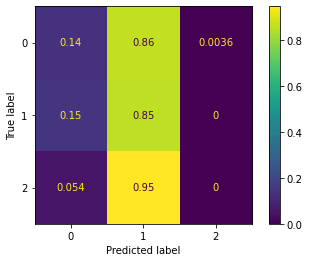

In [54]:
plot_confusion_matrix(model, x_test, y_test, normalize='true')

## Regression Model

This logistic binary regression model operates by taking a dog's zip code as input and attempting to predict whether the dog is neutered or not. The accuracy of the model is 0.52, signifying that its predictive performance is roughly at chance level or random, as it falls near the midpoint of the accuracy scale (ranging from 0 to 1).

In [12]:
#predict if dog was neutered based on zipcode
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

df = df.dropna(subset=['ZipCode'])
df = df.dropna()

X = df[['ZipCode']]
y = df['SpayNeuter']

# Split the data into a training set and test set using train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2)

# create logistic regression model
model = LogisticRegression()

# fit the logistic regression model and save predictions
model.fit(train_x, train_y)
predictions = model.predict(test_x)

# calculate accuracy for classification
accuracy = accuracy_score(test_y, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.52


# Conclusion
Through exploratory data analysis and use of machine learning models, we were able to answer the questions:
    1. Are dogs more likely to bite during different times of the year?
    2. What features of dogs (location, breed, gender) are most correlated with each other?
    3. Given certain features, can we predict the gender of a dog? 
    4. Can we accurately predict whether or not a dog is more likely to be neutered based on its zipcode?

We conclude that dogs are more likely to bite during the summer time and we suspect it to be due to the rise in temperatures that cause irritability and aggression in dogs. We conclude that where a dog is located in NYC and their breed as well as their age or gender have a weak correlation. Thus, we cannot say that breed is a good predictor of the borough in which the dog bite occurred. However, based on our classification model, given all of these features, we can predict fairly well the gender of a dog. In the future, we can explore this further by predicting the borough in which a dog bite occurred or the age of the dog. Lastly, we concluded that our regression model does not very accurately predict whether or not a dog is neutered or spayed based on their zip code. 
